# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [39]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-03-26 14:47:28--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-03-26 14:47:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [41]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [42]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [43]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [44]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [45]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [46]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [47]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler= None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        ave_loss = loss_accum / (i_step + 1)
        if scheduler is not None:
            scheduler.step(ave_loss)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            samples, labels = data
            samples_gpu = samples.to(device)
            labels_gpu = labels.to(device)
            outputs = model(samples_gpu)
            _, predicted = torch.max(outputs.data, 1)
            total += labels_gpu.size(0)
            correct += torch.sum(predicted == labels_gpu)
    return correct / total

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.385045, Train accuracy: 0.535577, Val accuracy: 0.722067
Average loss: 0.699419, Train accuracy: 0.787496, Val accuracy: 0.798512
Average loss: 0.603590, Train accuracy: 0.818534, Val accuracy: 0.820490
Average loss: 0.555738, Train accuracy: 0.833976, Val accuracy: 0.818374
Average loss: 0.524069, Train accuracy: 0.844572, Val accuracy: 0.820627


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [48]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:1303: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

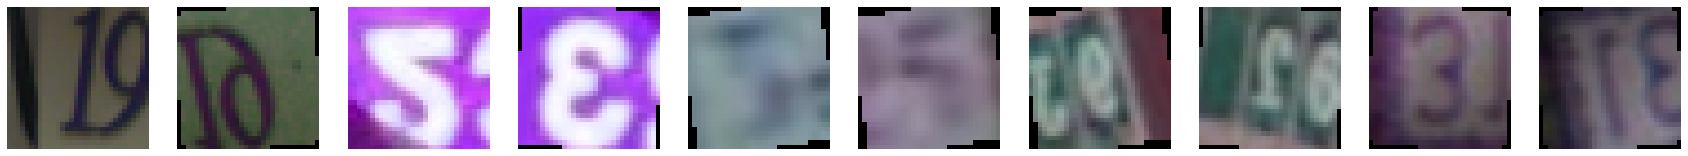

In [49]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [50]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])


# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [51]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.612681, Train accuracy: 0.811248, Val accuracy: 0.829909
Average loss: 0.565289, Train accuracy: 0.826025, Val accuracy: 0.807453
Average loss: 0.543279, Train accuracy: 0.834078, Val accuracy: 0.831684
Average loss: 0.530629, Train accuracy: 0.837764, Val accuracy: 0.848816
Average loss: 0.518541, Train accuracy: 0.842525, Val accuracy: 0.844789


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [52]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
              nn.Conv2d(3, 6, 5),
              nn.BatchNorm2d(6),
              nn.Tanh(),
              nn.MaxPool2d(2),
              nn.Conv2d(6, 16, 5),
              nn.BatchNorm2d(16),
              nn.Tanh(),
              nn.MaxPool2d(2),
              Flattener(),
              nn.Linear(16*5*5, 120),
              nn.Tanh(),
              nn.BatchNorm1d(120),
              nn.Linear(120, 84),
              nn.BatchNorm1d(84),
              nn.Tanh(),
              nn.Linear(84, 10),
              nn.BatchNorm1d(10),)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [53]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.998115, Train accuracy: 0.684896, Val accuracy: 0.834619
Average loss: 0.542393, Train accuracy: 0.836297, Val accuracy: 0.875640
Average loss: 0.469272, Train accuracy: 0.858649, Val accuracy: 0.883830
Average loss: 0.425799, Train accuracy: 0.870713, Val accuracy: 0.882192
Average loss: 0.396821, Train accuracy: 0.880661, Val accuracy: 0.893591
Average loss: 0.374188, Train accuracy: 0.887196, Val accuracy: 0.893932
Average loss: 0.356468, Train accuracy: 0.892468, Val accuracy: 0.901235
Average loss: 0.341834, Train accuracy: 0.895915, Val accuracy: 0.897277
Average loss: 0.331767, Train accuracy: 0.899294, Val accuracy: 0.898710
Average loss: 0.317487, Train accuracy: 0.903133, Val accuracy: 0.901440


# Подбор гиперпараметров

In [58]:
# # The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# # We also encourage you to try different optimizers as well
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg', 'opt'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history' ,'final_val_accuracy' ])

learning_rates = [1e-3, 1e-4]
reg = [1e-3, 1e-5, 1e-7]
optims = [optim.Adam]

batch_size = 64
epoch_num = 3

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

best_model = None
best_accuracy = 0
lenet_model = nn.Sequential(
      nn.Conv2d(3, 6, 5),
      nn.BatchNorm2d(6),
      nn.Tanh(),
      nn.MaxPool2d(2),
      nn.Conv2d(6, 16, 5),
      nn.BatchNorm2d(16),
      nn.Tanh(),
      nn.MaxPool2d(2),
      Flattener(),
      nn.Linear(16*5*5, 120),
      nn.Tanh(),
      nn.BatchNorm1d(120),
      nn.Linear(120, 84),
      nn.BatchNorm1d(84),
      nn.Tanh(),
      nn.Linear(84, 10),
      nn.BatchNorm1d(10),)
for lr in learning_rates:
  for rg in reg:
    for opt in optims:
      print("lrate: %f reg: %f" % (lr, rg))
      model = lenet_model
      model.type(torch.cuda.FloatTensor)
      model.to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=rg)
      scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)
      loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)  
      run_record[Hyperparams(lr, rg, opt)] = RunResult(lenet_model, train_history, val_history , val_history[-1])
      if val_history[-1] > best_accuracy:
        best_model = model 

lrate: 0.001000 reg: 0.001000
Average loss: 1.113821, Train accuracy: 0.669829, Val accuracy: 0.836462
Average loss: 0.620363, Train accuracy: 0.824284, Val accuracy: 0.859464
Average loss: 0.535208, Train accuracy: 0.844692, Val accuracy: 0.867859
lrate: 0.001000 reg: 0.000010
Average loss: 0.487229, Train accuracy: 0.854878, Val accuracy: 0.879257
Average loss: 0.440008, Train accuracy: 0.868034, Val accuracy: 0.886834
Average loss: 0.412687, Train accuracy: 0.876480, Val accuracy: 0.892499
lrate: 0.001000 reg: 0.000000
Average loss: 0.394052, Train accuracy: 0.881838, Val accuracy: 0.890997
Average loss: 0.368363, Train accuracy: 0.889346, Val accuracy: 0.895570
Average loss: 0.351490, Train accuracy: 0.894226, Val accuracy: 0.899188
lrate: 0.000100 reg: 0.001000
Average loss: 0.298820, Train accuracy: 0.911221, Val accuracy: 0.907788
Average loss: 0.284529, Train accuracy: 0.915777, Val accuracy: 0.907174
Average loss: 0.279167, Train accuracy: 0.917756, Val accuracy: 0.909221
lrat

In [59]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.0001, reg=1e-07, opt=<class 'torch.optim.adam.Adam'>)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [73]:
best_model = None
#batchnorm2d is in the lenet model. opt - adam.
lenet_model = nn.Sequential(
      nn.Conv2d(3, 6, 5),
      nn.BatchNorm2d(6),
      nn.Tanh(),
      nn.MaxPool2d(2),
      nn.Conv2d(6, 16, 5),
      nn.BatchNorm2d(16),
      nn.Tanh(),
      nn.MaxPool2d(2),
      Flattener(),
      nn.Linear(16*5*5, 120),
      nn.Tanh(),
      nn.BatchNorm1d(120),
      nn.Linear(120, 84),
      nn.BatchNorm1d(84),
      nn.Tanh(),
      nn.Linear(84, 10),
      nn.BatchNorm1d(10),)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

steps = 2
optimizer = optim.Adam(lenet_model.parameters(), lr=0.002, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
# scheduler = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 8, scheduler)

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average loss: 0.913066, Train accuracy: 0.726530, Val accuracy: 0.848338
Average loss: 0.514804, Train accuracy: 0.849026, Val accuracy: 0.879667
Average loss: 0.476153, Train accuracy: 0.858120, Val accuracy: 0.882670
Average loss: 0.431634, Train accuracy: 0.871122, Val accuracy: 0.885537
Average loss: 0.402904, Train accuracy: 0.878460, Val accuracy: 0.888062
Average loss: 0.378898, Train accuracy: 0.886906, Val accuracy: 0.893523
Average loss: 0.360938, Train accuracy: 0.891718, Val accuracy: 0.895092
Average loss: 0.347931, Train accuracy: 0.895096, Val accuracy: 0.895843


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [74]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.91
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.91
